In [ ]:
!pip install opencv-python
!pip install tensorflow==2.2.0rc0
#!pip install pyspark==2.4.5
#!pip install systemml

In [1]:
import tensorflow as tf
if not tf.__version__ == '2.2.0-rc0':
    print(tf.__version__)
    raise ValueError('please upgrade to TensorFlow 2.2.0-rc0, or restart your Kernel (Kernel->Restart & Clear Output)')

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
import sys,cv2, math
from io import BytesIO
import zipfile
import matplotlib.pyplot as plt
import numpy as np
#Keras for the model
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback

#Spark for the parallelization, didn't work as getting an SyntaxError when importing Keras2DML
#from pyspark import SparkContext, SparkConf
#from pyspark.sql import SQLContext, SparkSession
#from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType
#sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
#from pyspark.sql import SparkSession
#spark = SparkSession \
#    .builder \
#    .getOrCreate()
#!mkdir -p /home/dsxuser/work/systemml
#from systemml import MLContext, dml
#from systemml.mllearn import Keras2DML
#import numpy as np
#import time
#ml = MLContext(spark)
#ml.setConfigProperty("sysml.localtmpdir", "mkdir /home/dsxuser/work/systemml")
#print(ml.version())
    

In [4]:
images = []
labels=[]
streambodies = [streaming_body_1,streaming_body_2,streaming_body_3,streaming_body_4]
i=0
for streambody in streambodies:
    i=i+1
    zip_ref = zipfile.ZipFile(BytesIO(streambody.read()), 'r')
    my_list_file = zip_ref.namelist()
    for filepath in my_list_file:
        if filepath[-1] == 'g':
            image = cv2.imread(zip_ref.extract(filepath),0)
            
            #Resizing
            image = cv2.resize(image, (310, 310))
            #Normalization
            image = image / 255.

           # image = image[:,:,::-1]
            
            image = np.expand_dims(image, 0)
            #image = image.flatten()
            labels.append(i)
            images.append(image)
    zip_ref.close()
images = np.array(images)
labels = np.array(labels)

#df = pd.DataFrame(images)
df = pd.DataFrame(labels,columns = ['labels'])
labs = pd.get_dummies(df['labels'], prefix='label')
df = pd.concat([df,labs],axis=1)
df.drop(['labels'],axis=1, inplace=True)

df.head()

,label_1,label_2,label_3,label_4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


We are where we left last notebook. Now we are going to try to construct the model of ANN to be able to identify the elements in the image. The idea is then to train three identic models but each to identify a different element. 
The next code is heavily influenced by https://keras.io/guides/functional_api/ ; https://faroit.com/keras-docs/0.3.3/examples/#two-merged-lstm-encoders-for-classification-over-two-parallel-sequences ; https://stackoverflow.com/questions/43151775/how-to-have-parallel-convolutional-layers-in-keras

In [5]:
df = df.to_numpy()
#df = np.expand_dims(df, 0)
#df = np.reshape(df, [-1, 3, 1])

In [6]:
#print(np.shape(labs))
#df = df.drop(['label_1','label_2','label_3'],axis=1)
print(np.shape(df))
dim = np.shape(images)[2]
samp = np.shape(images)[0]
images = np.reshape(images, [-1, dim, dim, 1])
print(dim)
print(np.shape(images))

(1213, 4)
310
(1213, 310, 310, 1)


In [7]:
def general_model():
    input_shape = (dim,dim,1)
    inputs = keras.Input(shape=input_shape)
    # These are to be executed if the model is concatenated
    #x = layers.Conv2D(64,(5,5),strides=(3,3),activation='relu')(inputs)
    #x = layers.Dropout(0.3)(x)
    #x = layers.Conv2D(256,(6,6),strides=(4,4), activation='relu')(x)
    #x = layers.Dropout(0.3)(x)
    #x = layers.Conv2D(64,(6,6),strides=(4,4), activation='relu')(x)
    #x = layers.Conv2D(32,(5,5),strides=(4,4), activation='relu')(x)
    #x = layers.Dense(32, activation='relu')(x)
    #outputs = layers.Dense(1, activation='softmax')(x)
    
    #These are to be executed if the model is going to be individual
    x = layers.Conv2D(64,(5,5),strides=(3,3),activation='relu')(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(256,(6,6),strides=(4,4), activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64,(6,6),strides=(4,4), activation='relu')(x)
    x = layers.Conv2D(32,(5,5),strides=(4,4), activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    outputs = tf.keras.backend.squeeze(outputs, axis=1)
    outputs = tf.keras.backend.squeeze(outputs, axis=1)
    return keras.Model(inputs, outputs)

model_RazorBlade = general_model()
model_HandGun = general_model()
model_Shuriken = general_model()
#model_Knive = general_model()
model_Shuriken.summary()

#This is trying to make everything a single model, but I apparently failed somewhere as in the training nothing evolved...

#input_shape=(dim,dim,1)
#inputs = keras.Input(shape=input_shape)
#y1 = model_RazorBlade(inputs)
#y2 = model_HandGun(inputs)
#y3 = model_Shuriken(inputs)
#y4 = model_Knive(inputs)
#outputs = layers.Concatenate(axis=1)([y1, y2, y3, y4])
#outputs = tf.keras.backend.squeeze(outputs, axis=2)
#outputs = tf.keras.backend.squeeze(outputs, axis=2)
#ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

opt = keras.optimizers.Adam(learning_rate=0.001)
#opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.09)
#opt = tf.keras.optimizers.Adagrad(learning_rate=0.001)
#ensemble_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
#ensemble_model.summary()

# To train then the three model we will have to do it by hand...

model_RazorBlade.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
model_HandGun.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
model_Shuriken.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
#model_Knive.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 310, 310, 1)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 102, 102, 64)      1664      
_________________________________________________________________
dropout_4 (Dropout)          (None, 102, 102, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 25, 25, 256)       590080    
_________________________________________________________________
dropout_5 (Dropout)          (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 5, 64)          589888    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 32)          5123

In [8]:
epochs = 6
batch_size = 72
#Lets prepare the labels for each training
y1 = df[:,0]
y2 = df[:,1]
y3 = df[:,2]
#y4 = df[:,3]

#For Keras implementation
#samples = samp
#max_iter = int(epochs*math.ceil(samples/batch_size))
#model = Keras2DML(spark, ensemble_model, input_shape=input_shape, batch_size=batch_size, max_iter=max_iter, test_interval=0, display=10)
#ensemble_model.fit(images, df, epochs=epochs, batch_size=batch_size, shuffle=True, validatio_split = 0.3)

#print(y2)

In [9]:
#Lets train them
model_RazorBlade.fit(images, y1, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.3)
model_HandGun.fit(images, y2, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.3)
model_Shuriken.fit(images, y3, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.3)
#model_Knive.fit(images, y4, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=0.3)

Epoch 1/6
12/12 [==============================] - 32s 3s/step - loss: 0.7160 - accuracy: 0.8563 - val_loss: 0.1127 - val_accuracy: 1.0000
Epoch 2/6
12/12 [==============================] - 30s 3s/step - loss: 0.4284 - accuracy: 0.8587 - val_loss: 0.2182 - val_accuracy: 1.0000
Epoch 3/6
12/12 [==============================] - 28s 2s/step - loss: 0.2492 - accuracy: 0.8587 - val_loss: 0.0331 - val_accuracy: 1.0000
Epoch 4/6
12/12 [==============================] - 30s 2s/step - loss: 0.0869 - accuracy: 0.9800 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/6
12/12 [==============================] - 32s 3s/step - loss: 0.0733 - accuracy: 0.9776 - val_loss: 7.1023e-05 - val_accuracy: 1.0000
Epoch 6/6
12/12 [==============================] - 31s 3s/step - loss: 0.0685 - accuracy: 0.9812 - val_loss: 2.1939e-05 - val_accuracy: 1.0000
Epoch 1/6
12/12 [==============================] - 30s 3s/step - loss: 0.5096 - accuracy: 0.7491 - val_loss: 0.0981 - val_accuracy: 1.0000
Epoch 2/6
12/12 [==

In [10]:

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_5 = client_a1ed1d1752a148b4a48992d0e3394330.get_object(Bucket='coursera-donotdelete-pr-axvmevoatfvcja', Key='B0015_0002.png')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_5, "__iter__"): streaming_body_5.__iter__ = types.MethodType( __iter__, streaming_body_5 ) 


In [11]:
#Lets check how it works in another image
image_test = plt.imread(streaming_body_5)
print(np.shape(image_test))
#Resizing
image_test_r = cv2.resize(image_test, (dim, dim))
#Normalization
image_test_r = image_test_r / 255.
image_test_r = np.expand_dims(image_test_r, 0)
image_test_r = np.reshape(image_test_r, [-1, dim, dim, 1])

(452, 612)


(1, 310, 310, 1)
The model thinks that the odds that there is a Razor Blade in the image is [[0.]] % 
The model thinks that the odds that there is a Hand Gun in the image is [[86.62817]] % 
The model thinks that the odds that there is a Shuriken in the image is [[0.]] % 


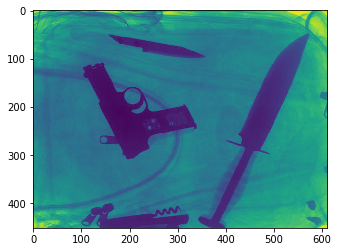

In [12]:
print(np.shape(image_test_r))
b = []
b.append(model_RazorBlade.predict(image_test_r)*100)
b.append(model_HandGun.predict(image_test_r)*100)
b.append(model_Shuriken.predict(image_test_r)*100)
#b.append(model_Knive.predict(image_test_r)*100)
print("The model thinks that the odds that there is a Razor Blade in the image is {} % ".format(b[0]))
print("The model thinks that the odds that there is a Hand Gun in the image is {} % ".format(b[1]))
print("The model thinks that the odds that there is a Shuriken in the image is {} % ".format(b[2]))
#print("The model thinks that the odds that there is a Knive in the image is {}  %".format(b[3]))

plt.imshow(image_test)


All of this looks good! We have now to prepare a nice notebook and pdf to present the hole project in a more correct way. So to be able to transport this model we will have to save each one of the models. 

In [13]:
model_RazorBlade_result_path = "model_RazorBlade.h5"
model_HandGun_result_path = "model_HandGun.h5"
model_Shuriken_result_path = "model_Shuriken.h5"
model_RazorBlade.save(model_RazorBlade_result_path)
model_HandGun.save(model_HandGun_result_path)
model_Shuriken.save(model_Shuriken_result_path)

In [32]:
!tar -zcvf model_RazorBlade.tgz model_RazorBlade.h5 
!tar -zcvf model_HandGun.tgz  model_HandGun.h5 
!tar -zcvf model_Shuriken.tgz model_Shuriken.h5

model_RazorBlade.h5
model_HandGun.h5
model_Shuriken.h5




#######################################################################################

Synchronous deployment creation for uid: '1efc42ef-8d19-4951-9367-6c47692cb751' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS....
DEPLOY_FAILURE

--------------------------
Deployment creation failed
--------------------------


Incorrect input data: Unexpected type of 'ScoringMeta element', expected: '<class 'int'>', actual: '<class 'tuple'>'.


WMLClientError: Deployment creation failed. Errors: [{'code': 'invalid_input_data', 'message': "Incorrect input data: Unexpected type of 'ScoringMeta element', expected: '<class 'int'>', actual: '<class 'tuple'>'.", 'target': {'type': 'none', 'name': 'none'}, 'more_info': 'none'}]

In [40]:
from ibm_botocore.client import Config
import ibm_boto3
def upload_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.upload_file(Filename=local_file_name, Bucket=credentials['BUCKET'],Key=key)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Uploaded')


File Uploaded


File Uploaded
File Uploaded
